<a href="https://colab.research.google.com/github/rafael-ariascalles/MachineLearningExamples/blob/main/Cluster_Anaysis_of_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
#!pip install scikit-learn==0.24.2
#!pip install -U yellowbrick

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,InterclusterDistance


from scipy.cluster.hierarchy import dendrogram 

### Utils

In [3]:
#SKlearn and GreatLearning Code

def data_understanding(df):
    n_rows, n_columns = df.shape
    print("------------ SAMPLE DATA ----------------------")
    display(data.sample(10).head())
    print("Number of Columns: {} and Rows: {}".format(n_columns,n_rows))
    print("------------ INFORMATION ----------------------")
    print(df.info())
    print("------------ NUMERIC TYPE ---------------------")
    dm = df.describe()
    display(dm)
    print(dm.columns)



def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram


def bar_correlation(corr_matrix,feature,threshold):
    plt.figure(figsize=(15,5))
    z = corr_matrix[feature].sort_values(ascending=False)
    z = z[abs(z.values) > threshold]
    sns.barplot(x=z.index, y=z.values)
    plt.xticks(rotation=90)
    plt.show()

def corr_plot(corr_matrix):
    plt.figure(figsize=(15,15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix,cmap=cmap)
    plt.show()

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Business Objective

Understand the type of customers for a better expirience within the Bank

### Data Understanding


In [4]:
data = pd.read_excel("drive/MyDrive/PGP-AIML/Credit Card Customer Data.xlsx")

In [5]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
data_understanding(data)

------------ SAMPLE DATA ----------------------


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
401,402,75792,48000,4,4,0,3
123,124,63663,17000,1,1,4,8
111,112,83244,12000,2,0,4,9
60,61,29759,20000,4,1,4,7
653,654,51826,95000,10,0,15,1


Number of Columns: 7 and Rows: 660
------------ INFORMATION ----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB
None
------------ NUMERIC TYPE ---------------------


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')


### Exploratory Data Analysis

Serial Number and Customer Key will be remove from the beggining 

### Univariate 

In [7]:
data.drop(["Sl_No","Customer Key"],1,inplace=True)

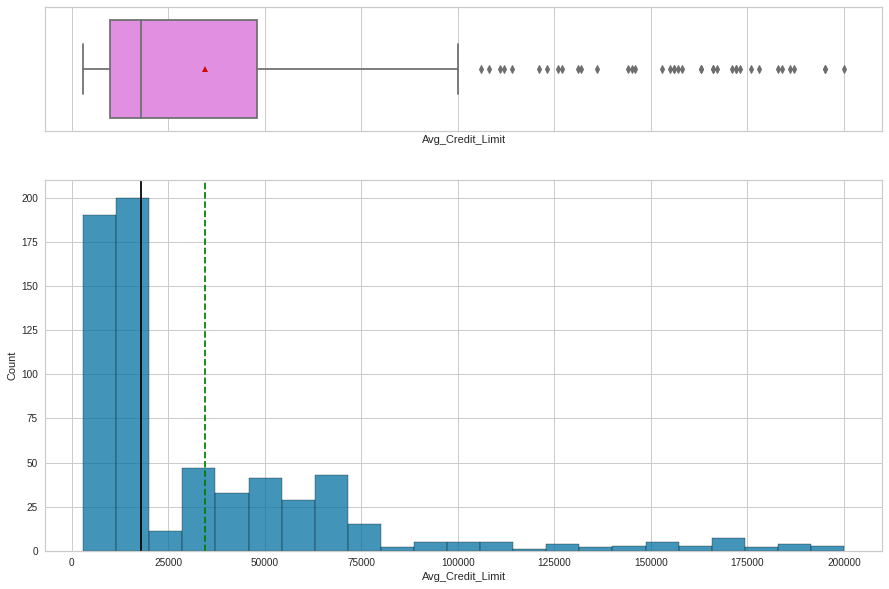

In [8]:
histogram_boxplot(data.Avg_Credit_Limit)

the plot shows that there could be 3 types og groups. 1 that is a Entry Level Credit Limit, 2) Retailer Credit Limit and 3) Premium Credit Limits. Left Skeww Distribution

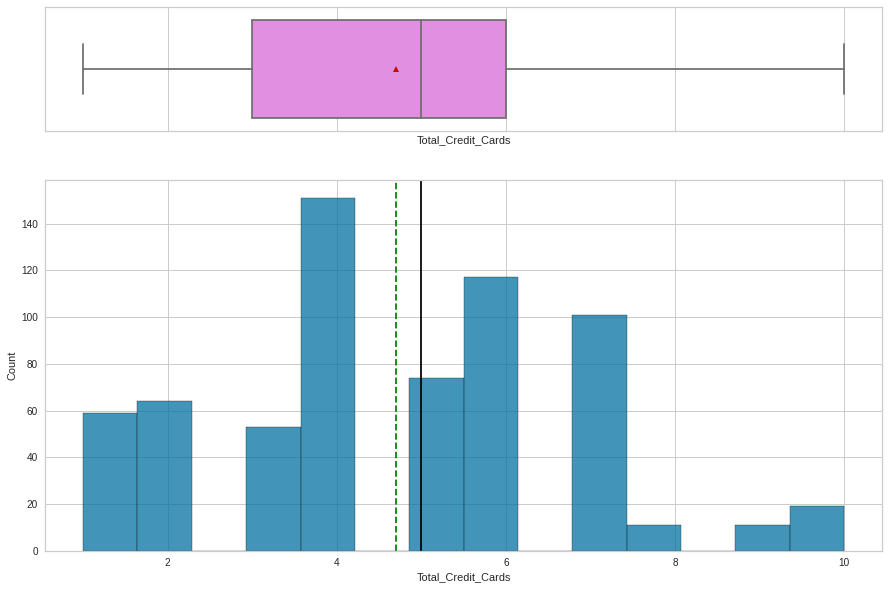

In [9]:
histogram_boxplot(data.Total_Credit_Cards)


Customer has in average a mediam of 5 Credit Cards. these has to be Constrast with the Avg Credit Limit, Because is a Customer level Agregation we will have to explore The average credit limit per Card

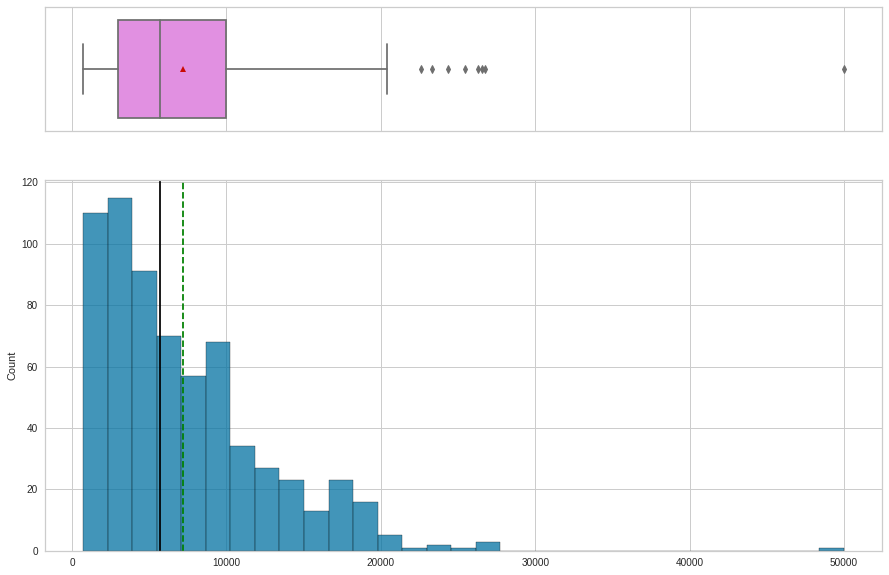

In [10]:
histogram_boxplot(data.Avg_Credit_Limit/data.Total_Credit_Cards)

Information per Credit card Show that average limit within a Card is 8K.

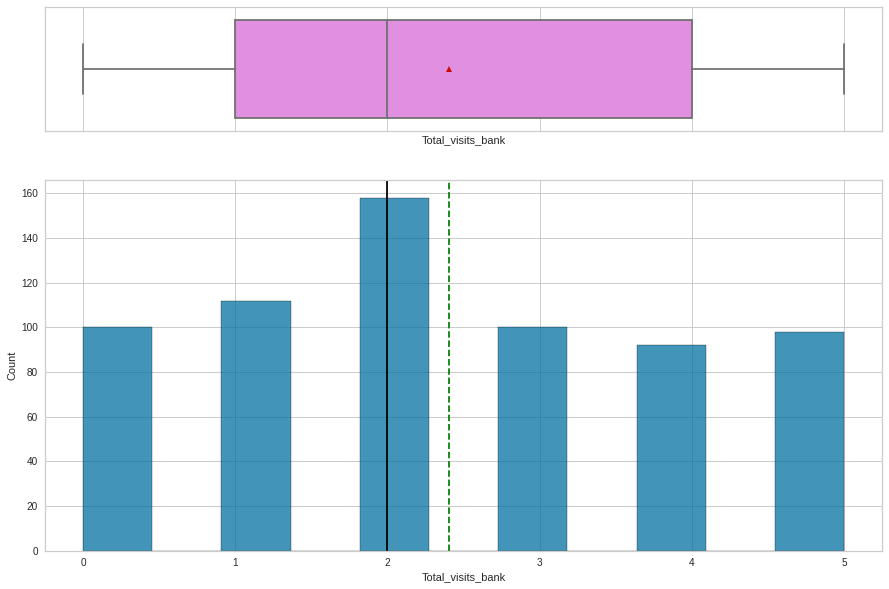

In [11]:
histogram_boxplot(data.Total_visits_bank)

With respect to visit to the bank the average goes 2 times but when mesure how many times per Credit card that it has it is show that it goes one or none per Crredit Card (Above Graph)

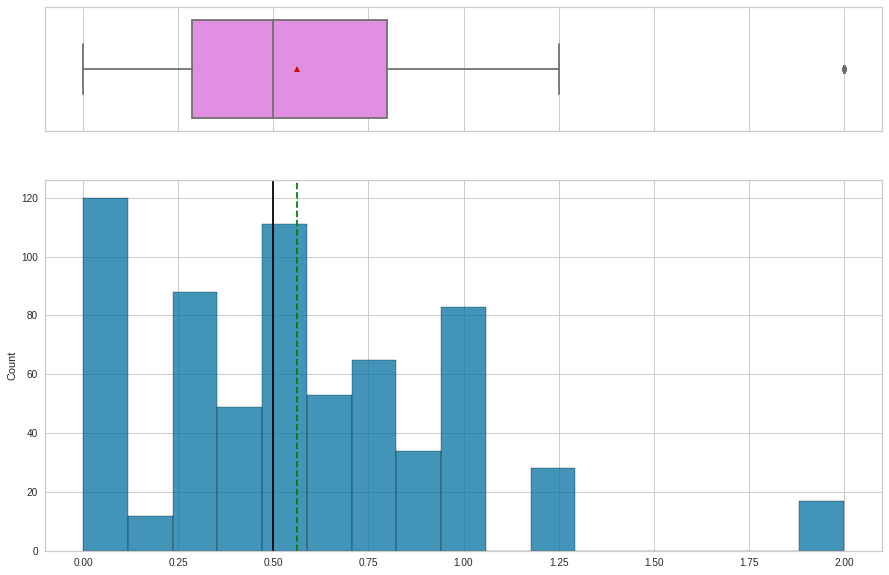

In [12]:
histogram_boxplot(data.Total_visits_bank/data.Total_Credit_Cards)

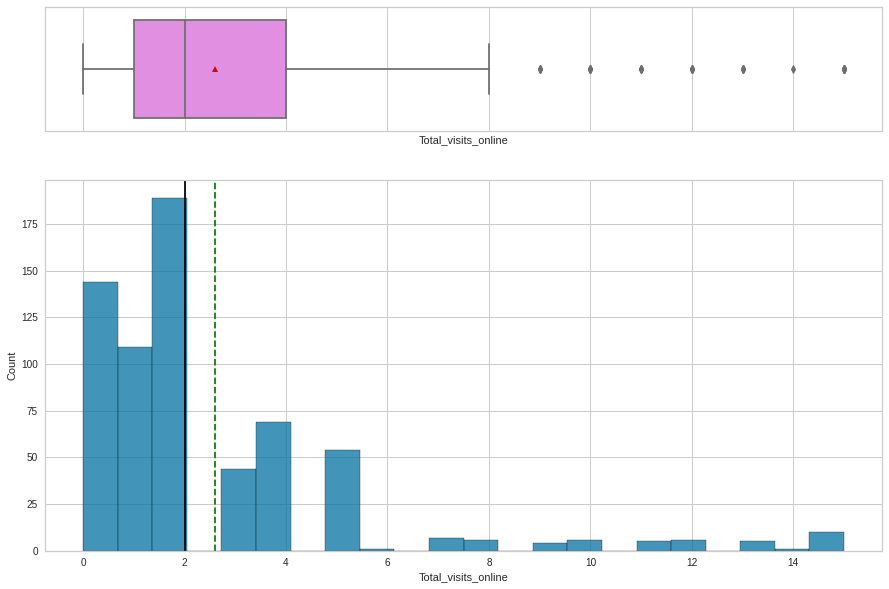

In [13]:
histogram_boxplot(data.Total_visits_online)

the exists some customer that visit more than 8 times the Online channels. These could be consider an outlier behavior but it may also depent on the number of Creditcards that it has

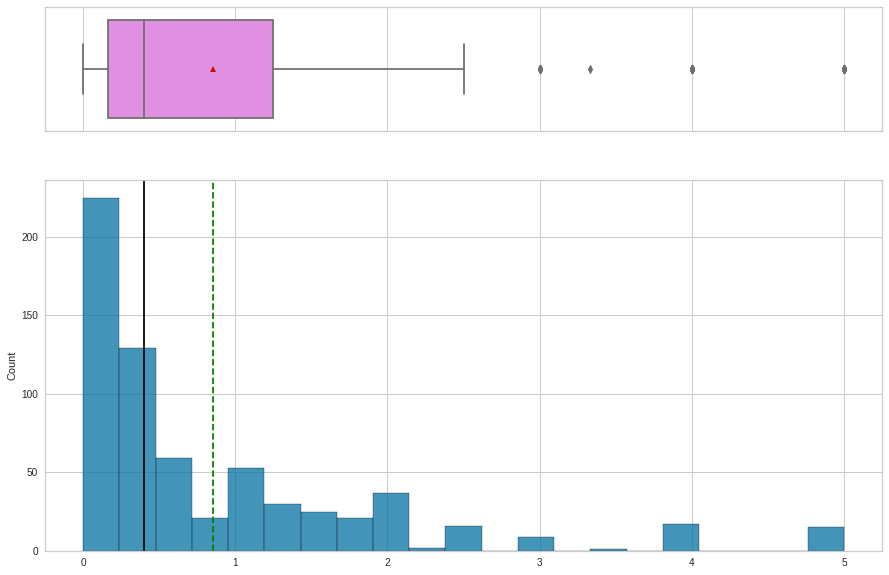

In [14]:
histogram_boxplot(data.Total_visits_online/data.Total_Credit_Cards)

If is compare visit Onlines per Credit Card, it looks like there exist customer that the behavior is to visit almost 1 to 2 times per Credit Card

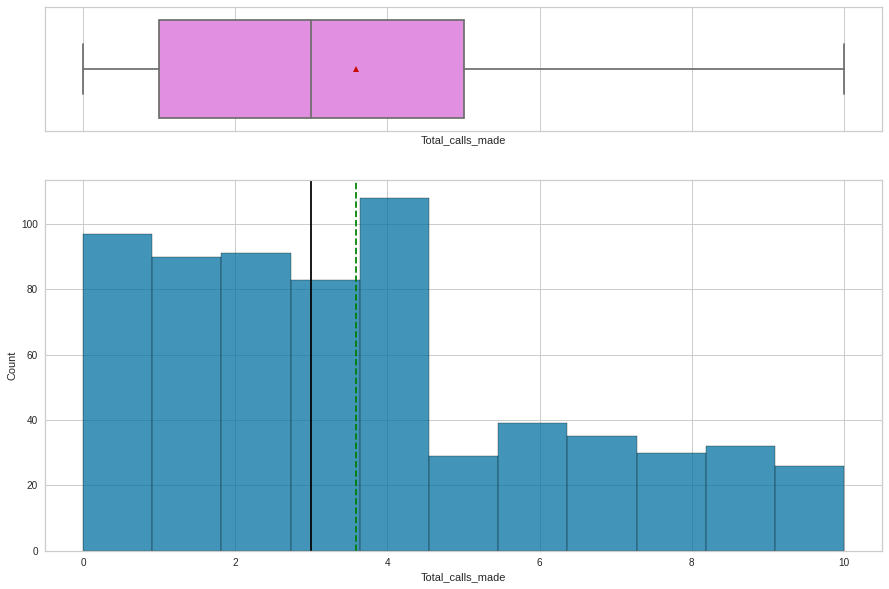

In [15]:
histogram_boxplot(data.Total_calls_made)

For the Calls that a customer can made it seems like the average customer made 4 to 3 calls and almost 1 or 2 per Credit card.

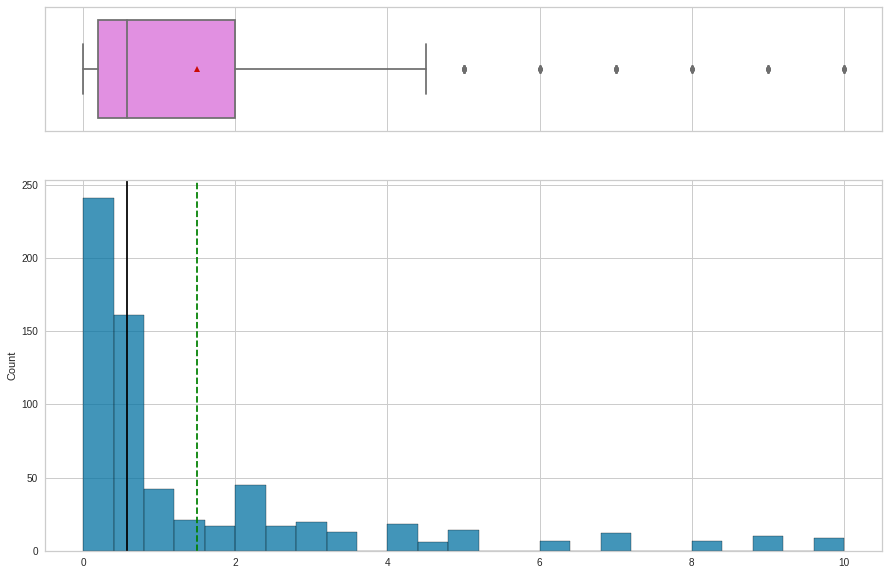

In [16]:
histogram_boxplot(data.Total_calls_made/data.Total_Credit_Cards)

All these plot have present the distribution of the variables and the vision of Per credit Card. for further decision we will plot the pair behavior to see if just the number of Credit card have a high correlation and modify the distribution of the other variables

### Multivariate

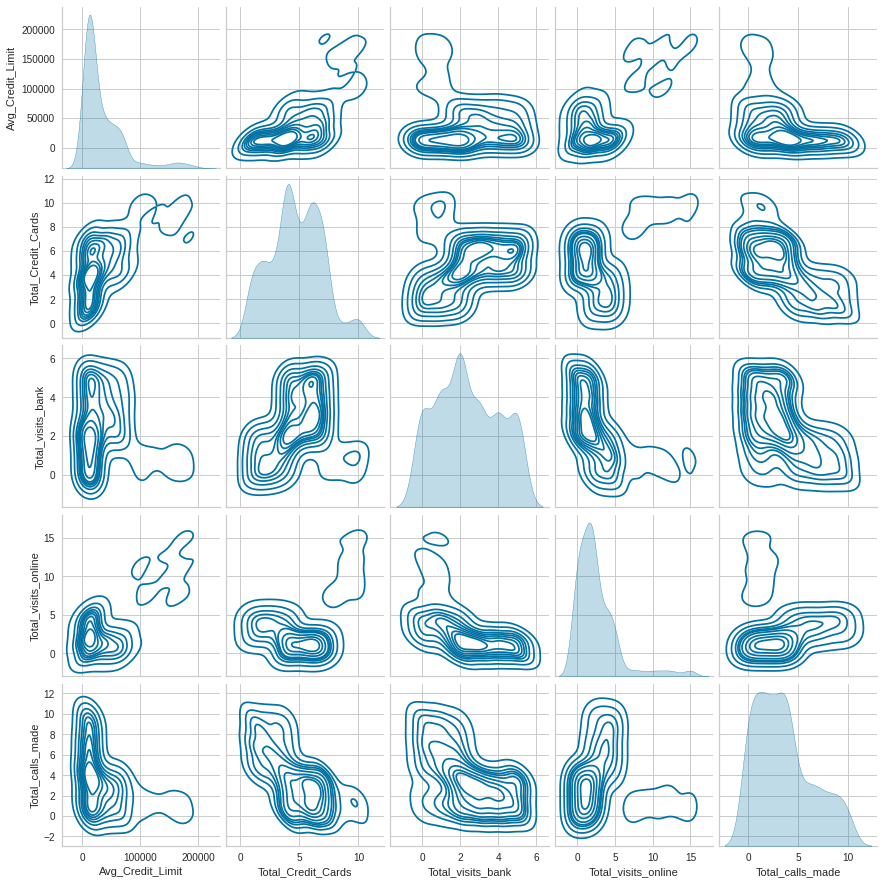

In [17]:
sns.pairplot(data,kind="kde")

The average credit limits is concentrate in low credit limit and it not dependes over the total number of credit cards and the behavior of comunication of the clients. even thought we can see that have higher credit limit visit more online. with respect to the other variable it seems that we have different preference between the nehavior of comunication given the Vaerage credit limit and the total Credit Cars. we have explore the variables Per car and it seems like the exist a correlation but we will explore that pattern doing Cluster.  

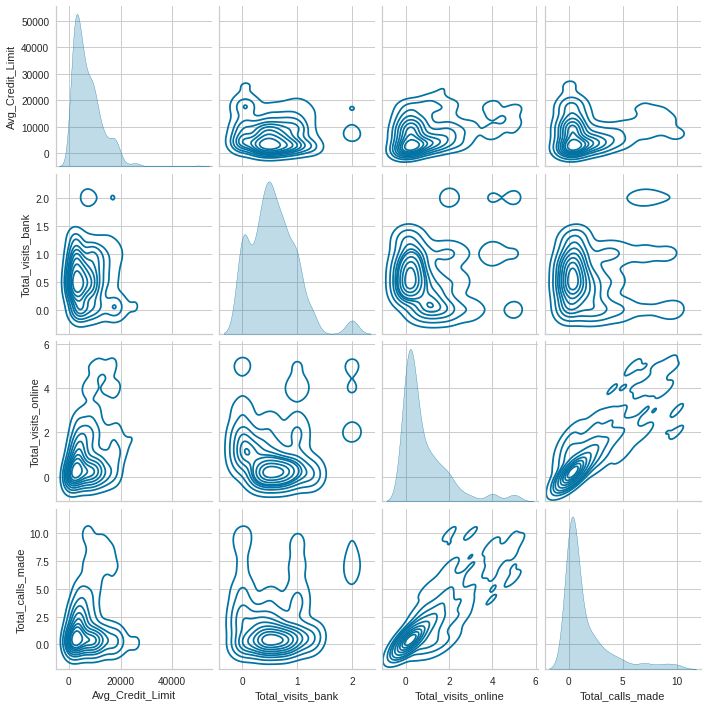

In [18]:
sns.pairplot(data.apply(lambda x: x/data.Total_Credit_Cards).drop(["Total_Credit_Cards"],1),kind="kde")

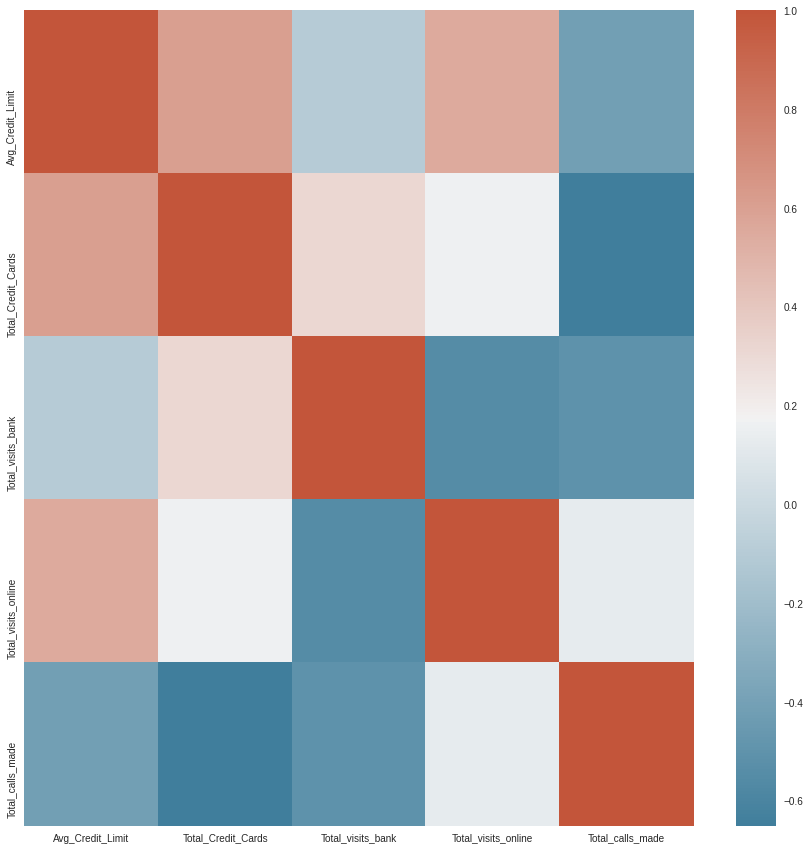

In [19]:
corr = data.corr()
corr_plot(corr)

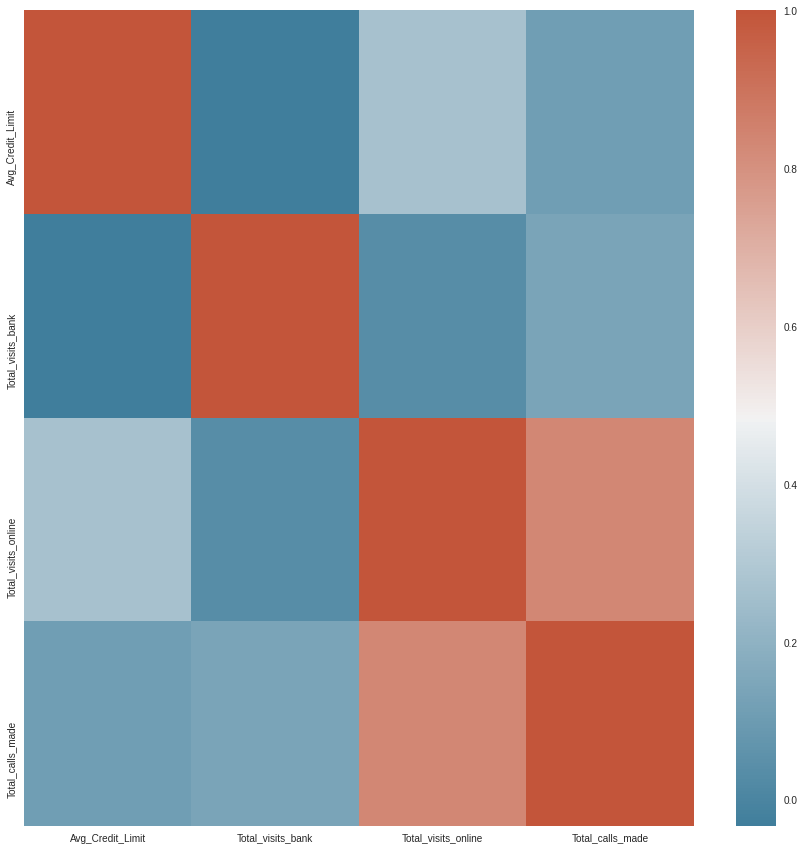

In [20]:
corr = data.apply(lambda x: x/data.Total_Credit_Cards).drop("Total_Credit_Cards",1).corr()
corr_plot(corr)

Seeing correlation it seems that is not necesary to have a PCA analysis but ot looks like there exist a correlation between Clients and the perspective bewteen Credit Card. it will be implement a Standard Scalar for all the variables   

In [21]:
preprocessing_def = []
for name in data:
    preprocessing_def.append(([name],[StandardScaler()]))

In [22]:
mapper = DataFrameMapper(preprocessing_def,df_out=True)

### Model development

##### Kmeans Cluster 

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9907723334708022
Number of Clusters: 6 	Average Distortion: 0.9429733447212403
Number of Clusters: 7 	Average Distortion: 0.9092607909955992
Number of Clusters: 8 	Average Distortion: 0.8902445936981452


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

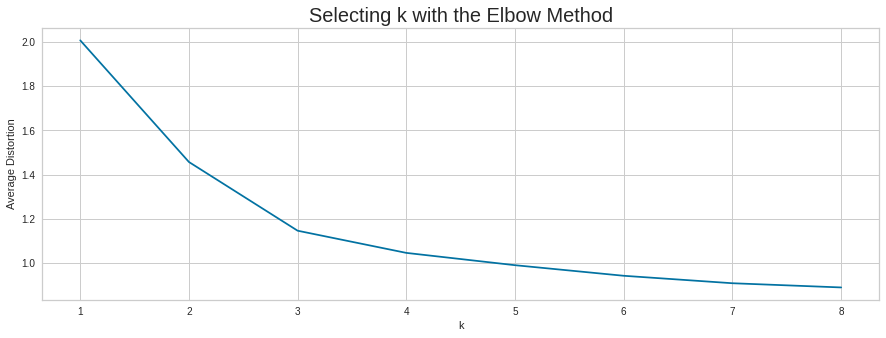

In [23]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=Pipeline([("pre_processing", mapper), ("model",KMeans(k))])
    model.fit(data)
    prediction=model.predict(data)
    distortion=sum(np.min(cdist(model.steps[0][-1].transform(data), model.steps[-1][-1].cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.figure(figsize=(15,5))
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

An Appropiate value of K with the Elbow Curve method seems to be 3 (given the Shape of it)

In [24]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = Pipeline([("pre_processing", mapper), ("model",KMeans(n_clusters))])
    preds = clusterer.fit_predict(data)
    score = silhouette_score(clusterer.steps[0][-1].transform(data), preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41842496663203593)
For n_clusters = 3, silhouette score is 0.5157182558879816)
For n_clusters = 4, silhouette score is 0.35566706193720643)
For n_clusters = 5, silhouette score is 0.2717470361083872)
For n_clusters = 6, silhouette score is 0.2558365757107384)
For n_clusters = 7, silhouette score is 0.2496212813037945)
For n_clusters = 8, silhouette score is 0.22727688029646448)
For n_clusters = 9, silhouette score is 0.21818066059508434)


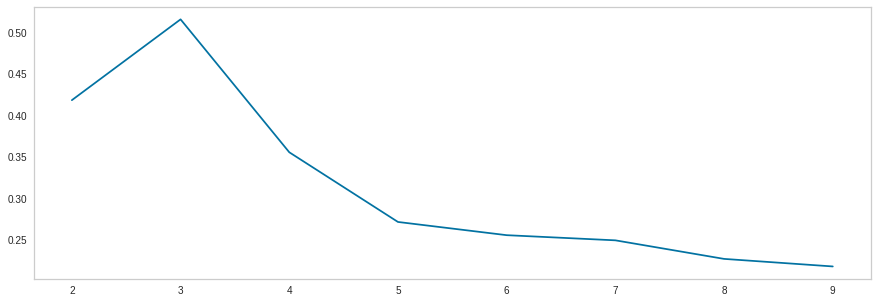

In [25]:
plt.figure(figsize=(15,5))
plt.plot(cluster_list,sil_score)
plt.grid()

It confirms that it seems like 3 is a good number for the cluster 

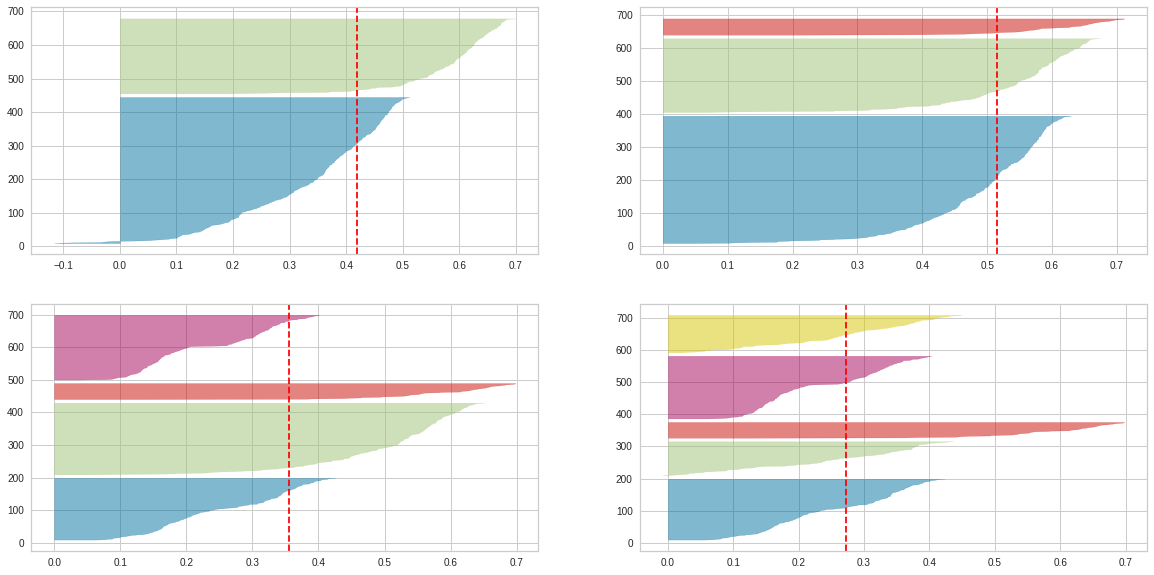

In [26]:
clusters=range(2,6)
fig, axs = plt.subplots(4//2,2,figsize=(20,10))
axs = axs.flatten()

for k,ax in zip(clusters,axs):
    visualizer = Pipeline([("pre_processing", mapper), ("model",SilhouetteVisualizer(KMeans(k),colors='yellowbrick', ax=ax,random_state=42, labels = False))])
    visualizer = visualizer.fit(data)
plt.show()

After all the analysis using centroid cluster methods it seems reasonable to use 3 Cluster, it would be fit a model with 3 Cluster and it would be Show the Distribution of these Groups

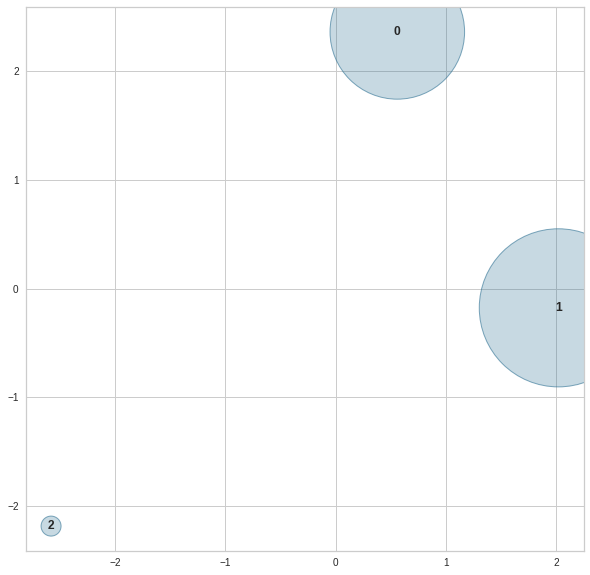

In [27]:
plt.figure(figsize=(10,10))
cluster = Pipeline([("pre_processing", mapper), ("model",InterclusterDistance(KMeans(3,random_state=8765),random_state=7614))])
cluster = cluster.fit(data)

In [92]:
result = pd.DataFrame(columns=["cluster","n_cluster","silhouette_score"])

In [93]:
result.loc[0] = ["kmeans",3,silhouette_score(cluster.steps[0][-1].transform(data),cluster.predict(data))]

In [94]:
result

,cluster,n_cluster,silhouette_score
0,kmeans,3,0.515718


##### Hierachical Cluster

In [83]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity='euclidean',linkage='ward'))])
hcluster = hcluster.fit(data)

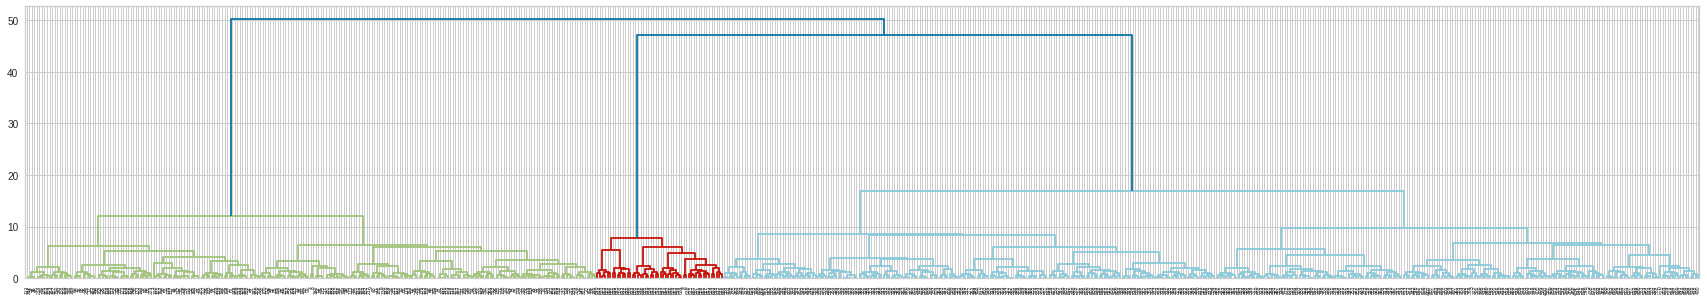

In [84]:
plt.figure(figsize=(30,5))
plot_dendrogram(hcluster.steps[-1][-1])

It seems like we have 3 groups again (Ward is very similar to Kmeas)

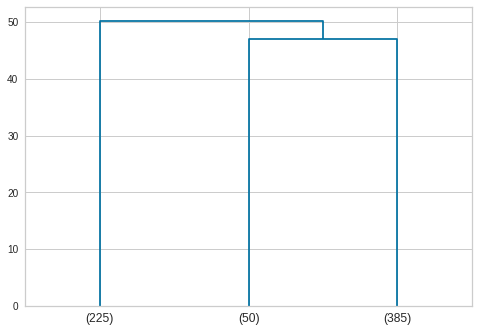

In [85]:
plot_dendrogram(hcluster.steps[-1][-1], truncate_mode='lastp',p=3)

In [96]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward'))])
hcluster_group = hcluster.fit_predict(data)

In [97]:
result.loc[1] = ["linkage-ward",3,silhouette_score(hcluster.steps[0][-1].transform(data),hcluster_group)]

In [98]:
result

,cluster,n_cluster,silhouette_score
0,kmeans,3,0.515718
1,linkage-ward,3,0.514764


Kmeans and Ward has almost the similar Silhoutte Score

In [99]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity='euclidean',linkage='complete'))])
hcluster = hcluster.fit(data)

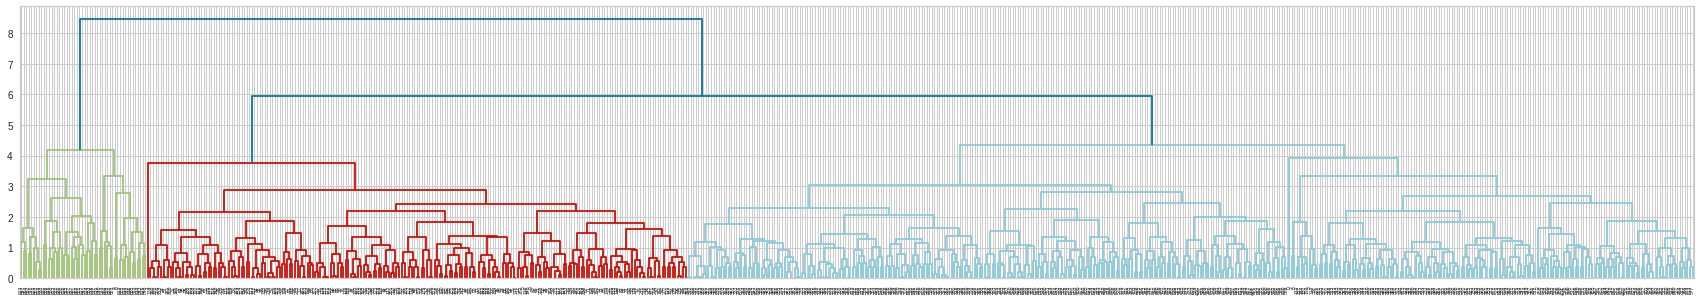

In [100]:
plt.figure(figsize=(30,5))
plot_dendrogram(hcluster.steps[-1][-1])

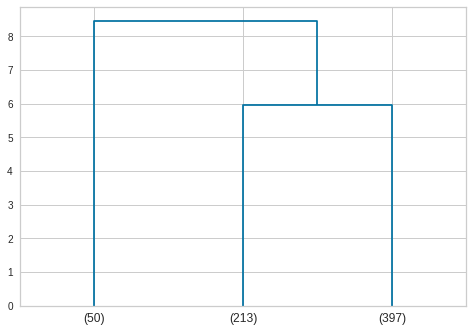

In [101]:
plot_dendrogram(hcluster.steps[-1][-1], truncate_mode='lastp',p=3)

In [103]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='complete'))])
hcluster_group = hcluster.fit_predict(data)


In [104]:
result.loc[2] = ["linkage-complete",3,silhouette_score(hcluster.steps[0][-1].transform(data),hcluster_group)]

In [105]:
result

,cluster,n_cluster,silhouette_score
0,kmeans,3,0.515718
1,linkage-ward,3,0.514764
2,linkage-complete,3,0.502644


Still Kmeas has a better Silhoute Score

In [106]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity='euclidean',linkage='average'))])
hcluster = hcluster.fit(data)

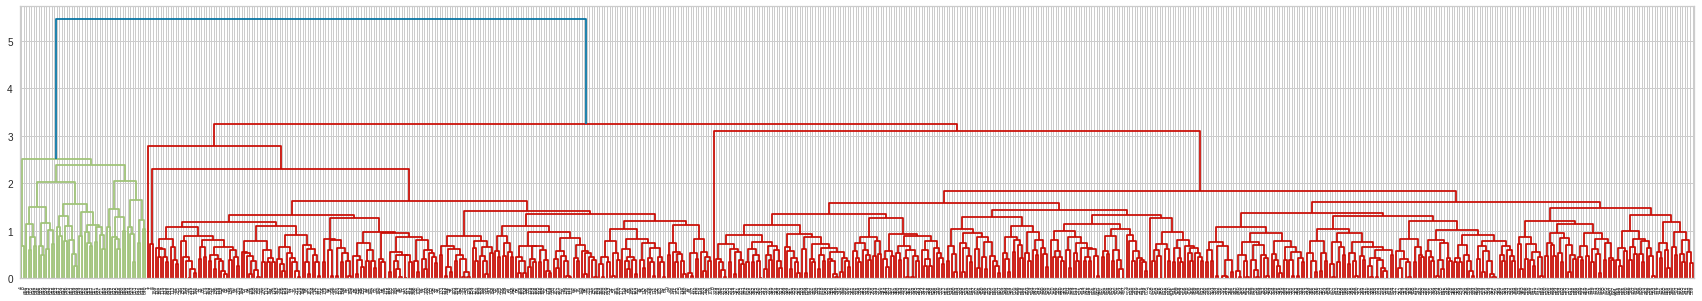

In [107]:
plt.figure(figsize=(30,5))
plot_dendrogram(hcluster.steps[-1][-1])

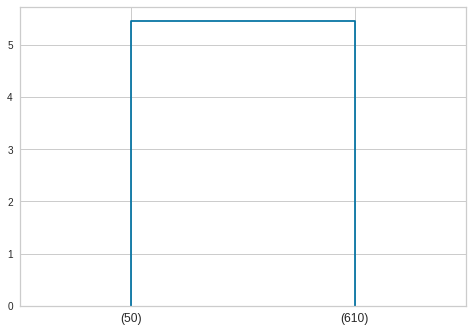

In [108]:
plot_dendrogram(hcluster.steps[-1][-1], truncate_mode='lastp',p=2)

In [142]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='average'))])
hcluster_group = hcluster.fit_predict(data)

In [143]:
result.loc[3] = ["linkage-average",2,silhouette_score(hcluster.steps[0][-1].transform(data),hcluster_group)]

In [144]:
result

,cluster,n_cluster,silhouette_score
0,kmeans,3,0.515718
1,linkage-ward,3,0.514764
2,linkage-complete,3,0.502644
3,linkage-average,2,0.570318
4,linkage-average,3,0.515922
5,linkage-single,3,0.374289


In [145]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='average'))])
hcluster_group = hcluster.fit_predict(data)

In [146]:
result.loc[4] = ["linkage-average",3,silhouette_score(hcluster.steps[0][-1].transform(data),hcluster_group)]

In [147]:
result

,cluster,n_cluster,silhouette_score
0,kmeans,3,0.515718
1,linkage-ward,3,0.514764
2,linkage-complete,3,0.502644
3,linkage-average,2,0.570318
4,linkage-average,3,0.515922
5,linkage-single,3,0.374289


It seems like if we use the Average Distance in agglomerative cluster we can get 2 Groups of Customer, we have seem a group of 50 Customer that have very similar behaviour.


In [116]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=None,distance_threshold=0,affinity='euclidean',linkage='single'))])
hcluster = hcluster.fit(data)

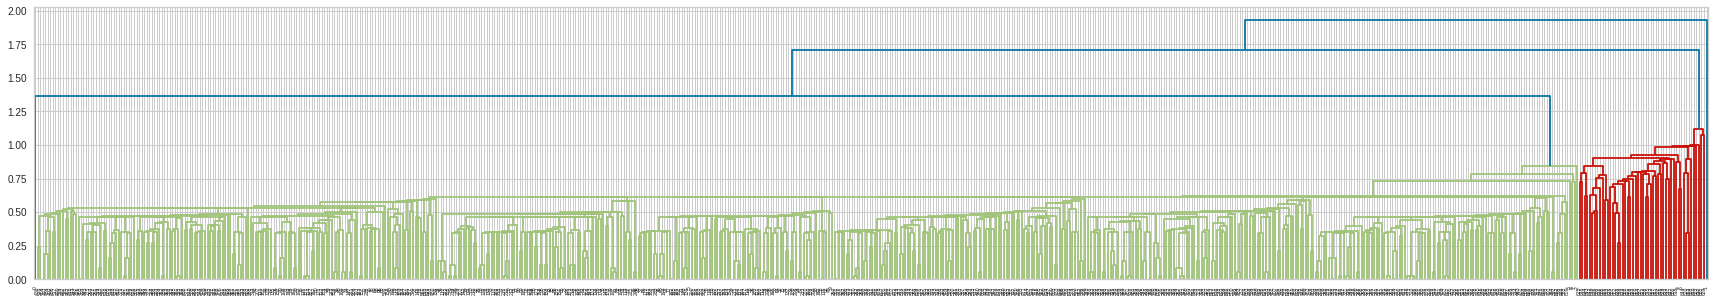

In [117]:
plt.figure(figsize=(30,5))
plot_dendrogram(hcluster.steps[-1][-1])

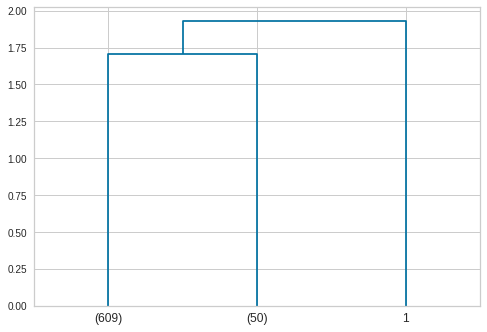

In [119]:
plot_dendrogram(hcluster.steps[-1][-1], truncate_mode='lastp',p=3)

In [120]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='single'))])
hcluster_group = hcluster.fit_predict(data)

In [122]:
result.loc[5] = ["linkage-single",3,silhouette_score(hcluster.steps[0][-1].transform(data),hcluster_group)]

In [128]:
result.sort_values(by="silhouette_score",ascending=False)

,cluster,n_cluster,silhouette_score
3,linkage-average,2,0.570318
4,linkage-average,3,0.515922
0,kmeans,3,0.515718
1,linkage-ward,3,0.514764
2,linkage-complete,3,0.502644
5,linkage-single,3,0.374289


##### Comparison

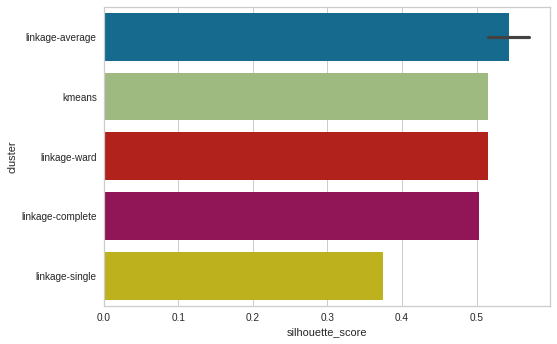

In [131]:
sns.barplot(y="cluster",x="silhouette_score",data=result.sort_values(by="silhouette_score",ascending=False))

It is clear that we have a Cluster of customers that has very clear the behavior (50 Customers). And that a cluster with the Average of all the pairs Sligthly better that Kmeas. We will Use Kmeans and LinkeAverage two just to see if it captures different Patterns 

### Model Evaluation

In [148]:
hcluster = Pipeline([("pre_processing", mapper), ("model",AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='average'))])
hcluster_group = hcluster.fit_predict(data)

In [149]:
cluster_group = cluster.predict(data)

In [150]:
data_clustered = data.copy()
data_clustered["hclust"] = hcluster_group
data_clustered["clust"] = cluster_group

In [152]:
cluster_profile = data_clustered.groupby('clust').mean()

In [153]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hclust
clust,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,0.0
1,33782.383420,5.515544,3.489637,0.981865,2.000000,0.0
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.0


In [154]:
cluster_profile.apply(lambda x: x/cluster_profile.Total_Credit_Cards)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hclust
clust,,,,,,
0,5050.000000,1.0,0.387037,1.474074,2.850000,0.000000
1,6124.941287,1.0,0.632691,0.178018,0.362612,0.000000
2,16137.299771,1.0,0.068650,1.247140,0.123570,0.114416


In these table is Shown that the customers capture by Hierarchical are the Same from Kmeans.

We can said that:

Cluster 0 is the customer that have some cards with "Retail" limits. and Use a lot no contact Channels.

Cluster 1 are the Mid Lever Limits Customers and like Human Interaction (because of the high Number of Visits per Card and as Clients) 


Cluster 2 are the Top Limits with lots of Cards like to be Online, are more practical but use more the Internet given the Number of Cards that it Has.


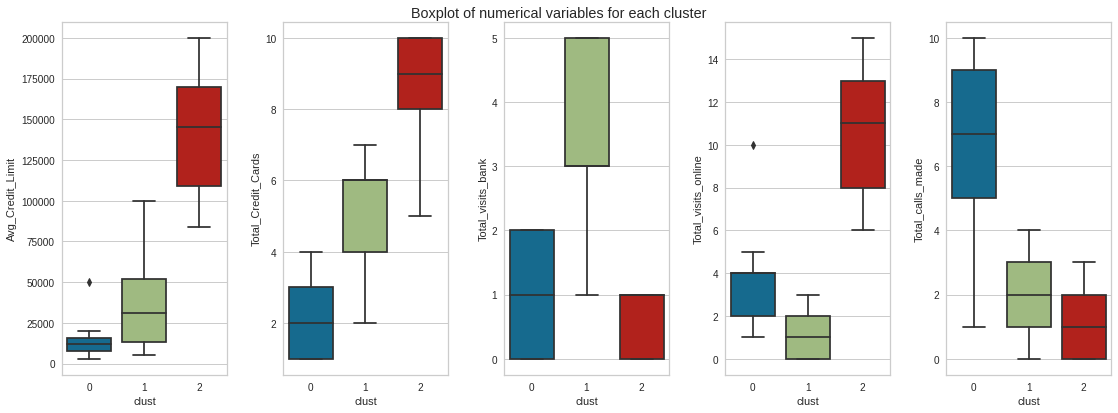

In [160]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0

for ii,name in zip(range(5),data_clustered.drop(["hclust","clust"],1)):
    sns.boxplot(ax=axes[ii],y=data_clustered[name],x=data_clustered['clust'])
    counter = counter+1

fig.tight_layout(pad=2.0)

### Business Insight

for these we can derive 2 big dimension that would be focused on what to offer and where to offer something to the Customer. 

For Cluster 0 - Our "Retail Caller" customer, can be Offer new promotions or Credit Card by Phone Calls Inbound and Outbound. 

For Cluster 1 - Our "Mid Level Agency Visitors", can be offer XSell or Product that take a bit more of time to Complete given that they are in the Bank Space (These customer in situation of COVID19 will need a way to supply his behaviour given that can these group could be the Non Digital Adopter hence in pandemic should need to be threated difference and with Patience)  

For Cluster 2 - Our "Top Digital Card Collectors", are customer that have lot of cards and like more Digital Chanels, Hence new products and XSell could be done in digital and could be necesarry to offer a product that can consolidate all the Card if needed 

